# INTRODUCTION

Style transfer means taking two images one content image and one style image and use them to create a new image which has the same structure and content as the content image but the colors and texture of the style image. The ground breaking paper [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) by Gatys et al. was the first to use deep learning for style transfer. Their method was able to stylize any content image given a style image. In the [previous notebook](https://github.com/shoabahamed/Nueral-Style-Transfer-Models/blob/master/ArtisticNeuralStyleTransfer.ipynb) we discussed about how it works. But it has several limitations. It was very slow to train for large images and you have to train seperately for each content and style image pair. The training parameters have to be tuned for each content and style pairs. 
To relove this problem Johnson et al. proposed the style transfer as an image transformation problem in their [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/abs/1603.08155) paper. Through this approach one can produce a stylized version of the content image in a single forward pass of the model. Their method is based on model optimization where they tune the model to capture the structure of the content image and colors, textures and patterns of the style image. 

In this notebook we will implement Fast Style Neural style transfer using the method described in perceptual loss paper. A lot of the code was taken from this [Fast Neural Style Transfer](https://www.kaggle.com/code/yashchoudhary/fast-neural-style-transfer) notebook and I would highly recommend that you check out this [Style Transfer in Real-Time](https://shafeentejani.github.io/2017-01-03/fast-style-transfer/) blogpost

<br>

***Prerequisites:***
<br>
* Basic Python & Pytorch
* Familiar with vgg model
<br>


***NOTE:*** This notebook is a continuation of my [previous notebook](https://github.com/shoabahamed/Nueral-Style-Transfer-Models/blob/master/ArtisticNeuralStyleTransfer.ipynb) so it is recomended that you check that out first.

# LIBRARIES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets
import torchvision.transforms.v2 as T
from torchvision import models
from torchvision.utils import make_grid, save_image


import os
import random
from tqdm.notebook import tqdm
from path import Path

%matplotlib inline

# CONFIGURATIONS

In [2]:
class CFG:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    batch_size = 4
    max_iterations = 40000 # no weight updates: increase this to train for more steps 
    
    content_img_size = (256, 256)
    style_img_size = (256, 256) # the content image and style image does necessarily have to be of the same size you can change it to larget image size
    seed = 1234
    
    train_model = False


    
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  
    

    
seed_everything(CFG.seed) # this function does note effect everyting globally

# HELPER FUNCTIONS

In [3]:
def show_images(images, labels, rows=2, figsize=(12, 5), title=""):
    """
    plot images of shape (B, C, H, W)
    
    images: (B, C, H, W)
    labels: List of strings
    """
    images = images.permute(0, 2, 3, 1).detach().cpu()  
    images = images.numpy()
    cols = max(1, len(images) // rows)
        
    if (rows, cols) == (1, 1):
        plt.imshow(images[0])
        plt.title(labels[0])
        plt.axis('off')
    else:
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        axes = axes.flatten()
        for img, label, ax in zip(images, labels, axes):
            ax.imshow(img)
            ax.set_title(f'{label}')
            ax.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()    
    

    

# DATASET & DATALOADER

For content images we will be using [Coco2014](https://www.kaggle.com/datasets/jeffaudi/coco-2014-dataset-for-yolov3) dataset for training 

In [4]:
class FlatFolderDataset(Dataset):
    def __init__(self, path, transform, take_images=None):
        super(FlatFolderDataset, self).__init__()
        self.root = path
        self.paths = sorted(list(Path(path).glob("*")))
        self.transform = transform
        
        if take_images is not None:
            self.paths = self.paths[:take_images]

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(str(path)).convert('RGB')
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.paths)

    
    
# transformations
def get_transform(img_size=None):
    transforms = []
    if img_size:
        transforms.append(T.Resize(size=img_size))  
            
    transforms.append(T.ToImage())  
    transforms.append(T.ToDtype(torch.float32, scale=True))
    transforms.append(T.ToPureTensor()) 
    
    return T.Compose(transforms)

In [5]:
seed_everything(CFG.seed)

train_path = "/kaggle/input/coco-2014-dataset-for-yolov3/coco2014/images/train2014"
valid_path = "/kaggle/input/coco-2014-dataset-for-yolov3/coco2014/images/val2014"

# train and valid transform of content images
train_transform = get_transform(CFG.content_img_size)
valid_transform = get_transform(CFG.content_img_size)

# creating train and valid dataset
train_content_dataset = FlatFolderDataset(train_path, train_transform)
valid_content_dataset = FlatFolderDataset(valid_path, valid_transform, take_images=CFG.batch_size * 100) # taking only 1600 images for validation

# creating train and valid dataloader with batch size of 8
train_content_dataloader = DataLoader(train_content_dataset, batch_size=CFG.batch_size, shuffle=True, pin_memory=True)
valid_content_dataloader = DataLoader(valid_content_dataset, batch_size=CFG.batch_size, shuffle=False, pin_memory=True)

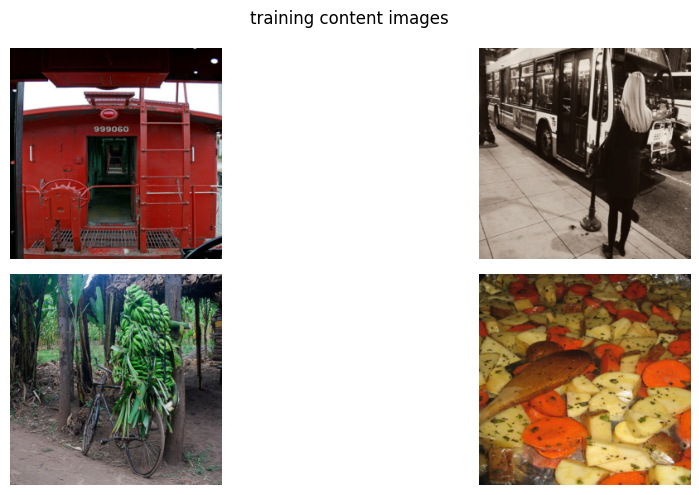

In [6]:
images = next(iter(train_content_dataloader))[:8]
labels = ["" for _ in range(len(images))]
show_images(images, labels, rows=2, title="training content images")

preparing style image

In [7]:
# the line below downloads our style image
!wget -O style_img.jpg https://raw.githubusercontent.com/shoabahamed/Nueral-Style-Transfer-Models/master/images/example_style_images/edtaonisl.jpg

--2024-11-05 13:51:33--  https://raw.githubusercontent.com/shoabahamed/Nueral-Style-Transfer-Models/master/images/example_style_images/edtaonisl.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 251507 (246K) [image/jpeg]
Saving to: 'style_img.jpg'

style_img.jpg       100%[===================>] 245.61K  --.-KB/s    in 0.04s   

2024-11-05 13:51:33 (5.50 MB/s) - 'style_img.jpg' saved [251507/251507]



In [8]:
style_path = "/kaggle/working/style_img.jpg" 
style_transform = get_transform(CFG.style_img_size)

style_img = style_transform(Image.open(style_path)).unsqueeze(0)

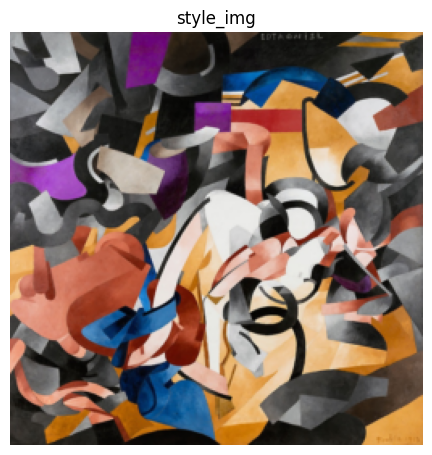

In [9]:
show_images(style_img, ['style_img'], rows=1)

# MODEL OVERVIEW

<img src="https://github.com/shoabahamed/Nueral-Style-Transfer-Models/blob/master/images/model_images/FastStyleNeuralStyleTransfer/system_overview.png?raw=True" style="display:block; margin: auto" title="Model Overview">
<p style="text-align: center; margin-top:1rem">Figure(modified):<a href="https://shafeentejani.github.io/2017-01-03/fast-style-transfer/"> <u>Image Transformation Network</u></a></p>

In fast nueral image transfer there are two components. One is Image Transformation newtork and another is Loss Network.

***Image Transformation Network:***
The network takes content image as input and try to generate an image which has the same content as the content image but it's colors, texture matches the style image.

***Loss Network/VGG Network:***
The loss network is a pretrained vgg16 network trained on Imagenet. It gets the features representation from relu1_2, relu2_2, relu3_3 and relu4_3 layer. All these layers feature maps would be used for computing style loss and content loss. These two loss would be used to guide the image transformation network to learn how to generate stylized version of the content image

# ImageTransformationNetwork
<img src="https://github.com/shoabahamed/Nueral-Style-Transfer-Models/blob/master/images/model_images/FastStyleNeuralStyleTransfer/image_transform_network.jpg?raw=True" style="display:block; margin: auto" title="Image Transformation Network">
<p style="text-align: center; margin-top:1rem">Figure:<a href="https://shafeentejani.github.io/2017-01-03/fast-style-transfer/"> <u>Image Transformation Network</u></a></p>

It is an encoder decoder network.
The first 9 blocks works as an encoder and encodes the image. The last three  blocks(excluding tanh) is the decoder responsible for upsampling the encoded image to its original size. Here the first two blocks of decoder has a stride=1/2 signifying fractionally strided convolution which is another way of saying we are using transpose convolution which increases input size by 2. The last decoder block is normal convolution layer. The last layer is a tanh layer which bounds the output values between -1 and 1. There are few things to notice here-

1. Only the first and last convolution uses kernel size of 9 * 9 all the other convolution layer uses kernel size of 3 * 3
2. In the paper they use reflection padding instead of zero padding during convolution to avoid border artifacts
3. Before each relu layer in the original paper they used BatchNormalization but it was later found that InstanceNormalization perform better for style transfer 
4. In the original paper Transpose Convolution was used for upsampling but they introduce checkerboard artifacts. So we used Nearest Upsampling. See the post [Deconvolution and Checkerboard Artifacts](https://distill.pub/2016/deconv-checkerboard/) for more details


In [10]:
class ImageTransformationNetwork(nn.Module):
    
    def __init__(self):
        super(ImageTransformationNetwork, self).__init__()
        
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = nn.InstanceNorm2d(128, affine=True)

        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)

        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)

        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):   
        """
        inputs:
            x: input of shape (B, 3, H, W)
        returns:
            y: stylized img of shape (B, 3, H, W)
        """
        # (Batch_Size, 3, Height, Width) -> (Batch_Size, 32, Height, Width)
        y = self.relu(self.in1(self.conv1(x)))
        # (Batch_Size, 32, Height, Width) -> (Batch_Size, 64, Height/2, Width/2)
        y = self.relu(self.in2(self.conv2(y)))
        # (Batch_Size, 64, Height/2, Width/2) -> (Batch_Size, 128, Height/4, Width/4)
        y = self.relu(self.in3(self.conv3(y)))

        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        # (Batch_Size, 128, Height/4, Width/4)-> (Batch_Size, 128, Height/4, Width/4)
        y = self.res5(y)

        # (Batch_Size, 128, Height/4, Width/4) -> (Batch_Size, 64, Height/2, Width/2)
        y = self.relu(self.in4(self.deconv1(y)))
        # (Batch_Size, 64, Height/2, Width/2) -> (Batch_Size, 32, Height, Width)
        y = self.relu(self.in5(self.deconv2(y)))
        # (Batch_Size, 32, Height, Width) -> (Batch_Size, 3, Height, Width)
        y = self.deconv3(y)
        
        y = F.tanh(y) 
        
        return y


<img src="https://github.com/shoabahamed/Nueral-Style-Transfer-Models/blob/master/images/model_images/FastStyleNeuralStyleTransfer/residual_layer.png?raw=True" style="display:block; margin: auto" title="Image Transformation Network">
<p style="text-align: center; margin-top:1rem">Figure:<a href="https://shafeentejani.github.io/2017-01-03/fast-style-transfer/"> <u>Residual Layer</u></a></p>

In [11]:
class ConvLayer(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        
        padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)

        return out
    

class ResidualBlock(nn.Module):

    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        self.conv1 = ConvLayer(in_channels, in_channels, kernel_size=3, stride=1)
        self.in1 = nn.InstanceNorm2d(in_channels, affine=True)
        self.conv2 = ConvLayer(in_channels, in_channels, kernel_size=3, stride=1)
        self.in2 = nn.InstanceNorm2d(in_channels, affine=True)

        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        residual = x

        out = self.relu(self.in1(self.conv1(x)))
        out = self.relu(self.in2(self.conv2(out)))
        out = out + residual

        return out

class UpsampleConvLayer(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

# LOSS NETWORK

<img src="https://github.com/shoabahamed/Nueral-Style-Transfer-Models/blob/master/images/model_images/ArtisticNeuralStyleTransfer/original.jpg?raw=true" style="display:block; margin: auto" title="how style transfer work">
<p style="text-align: center; margin-top:1rem">Figure:<a href="https://devpost.com/software/imageblender#updates">Loss network</a></p>

The loss network is a pretrained vgg16 network which remains frozen during training. We only use it calculate content and style loss. In the paper they used two perceptual losses:

<br>

***Feature Reconstruction Loss:***

Here content loss is the mean squred error between feature maps of relu2_2 between content image and generated stylized image. By minimizing this we want to make the model construct the content images structure as much as possible.
<br>

***Style Reconstruction Loss:***

Style loss is calculated as the mean squared error between style img gram matrix and content image gram matrix same as [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) paper. Gram matrix is calculated from feature maps of relu1_2, relu2_2, relu3_3, and relu4_3

> You can think of gram matrix here as the correlation between different channels in feature maps. We are trying to tell the model that if two feature map always occurs at the same time on the style image then also want them occur at the same time in to our generated stylized image. Suppose we have feature maps (C, H, W) at l layer of the network for style image. If small red shapes and blue strokes always appear in the stylize image we also want them to occur in our stylized image by minimizing this loss

In [12]:
class CustomVGG16(nn.Module):
    def __init__(self):
        super(CustomVGG16, self).__init__()
        
        self.normalizer = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
        # block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding="same")
        self.relu1 = nn.ReLU(inplace=False)  # relu1_1
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding="same")
        self.relu2 = nn.ReLU(inplace=False)  # relu1_2
        self.maxPool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # block 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding="same")
        self.relu3 = nn.ReLU(inplace=False)  # relu2_1
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding="same")
        self.relu4 = nn.ReLU(inplace=False)  # relu2_2
        self.maxPool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # block 3
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding="same")
        self.relu5 = nn.ReLU(inplace=False)  # relu3_1
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding="same")
        self.relu6 = nn.ReLU(inplace=False)  # relu3_2
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding="same")
        self.relu7 = nn.ReLU(inplace=False)  # relu3_3
        self.maxPool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # block 4
        self.conv8 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding="same")
        self.relu8 = nn.ReLU(inplace=False)  # relu4_1
        self.conv9 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding="same")
        self.relu9 = nn.ReLU(inplace=False)  # relu4_2
        self.conv10 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding="same")
        self.relu10 = nn.ReLU(inplace=False)  # relu4_3
        self.maxPool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # block 5
        self.conv11 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding="same")
        self.relu11 = nn.ReLU(inplace=False)  # relu5_1
        self.conv12 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding="same")
        self.relu12 = nn.ReLU(inplace=False)  # relu5_2
        self.conv13 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding="same")
        self.relu13 = nn.ReLU(inplace=False)  # relu5_3
        self.maxPool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        self.__load_weights__()
        for param in self.parameters():
            param.requires_grad = False
                
    def forward(self, x):
        """
        Takes in an input image of shape: (B, C, H, W) and outputs an dictionary with feature maps of layers relu1_2, relu2_2, relu3_3 and relu4_3.
        """
        output = {}
        
        # normalize values with mean and std of vgg network
        x = self.normalizer(x)
        
        # block 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        output['relu1_2'] = x
        x = self.maxPool1(x)
        
        # block 2
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        output['relu2_2'] = x
        x = self.maxPool2(x)
        
        # block 3
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.conv6(x)
        x = self.relu6(x)
        x = self.conv7(x)
        x = self.relu7(x)
        output['relu3_3'] = x
        x = self.maxPool3(x)

        
        # block 4
        x = self.conv8(x)
        x = self.relu8(x)
        x = self.conv9(x)
        x = self.relu9(x)
        x = self.conv10(x)
        x = self.relu10(x)
        output['relu4_3'] = x
        # we only need outputs till relu4_3 for loss calculation
        
        return output
    
    def __load_weights__(self):
        print("Loading pretrained loss network weights")
        pretrained_model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features
        pretrain_conv_layers = [layer for layer in pretrained_model if isinstance(layer, nn.Conv2d)]
        custom_conv_layers = [layer for layer in self.modules() if isinstance(layer, nn.Conv2d)]

        assert len(pretrain_conv_layers) == len(custom_conv_layers), "no of weight layers do not match"

        for custom_conv_layer, pretrain_conv_layer in zip(custom_conv_layers, pretrain_conv_layers):
            custom_conv_layer.weight.data = pretrain_conv_layer.weight.data.clone()
            custom_conv_layer.bias.data = pretrain_conv_layer.bias.data.clone()
            
        print("Weights Loaded")

# TRAINING

In [13]:
def get_gram_matrix(feature_map):
    """
    calculates the gram matrix given features maps of layer l
    feature_map: (Batch_Size, Channels, Height, Width)
    """
    # feature_map: (Batch_Size, Channels, Height, Width)
    
    B, C, H, W = feature_map.size() 
    # (Batch_Size, Channels, Height, Width) -> (Batch_Size, Channels, Height*Width)
    features = feature_map.view(B, C, H*W)
    # (Batch_Size, Channels, Height*Width) @ (Batch_Size, Height*Width, Channels) -> (Channels, Channels)
    gram_matrix = torch.bmm(features,  features.transpose(1, 2)) 
    
    return gram_matrix.div(C*W*H) # normalizing the gram matrix according to the paper 


def calculate_total_loss(content_feature_maps, generated_feature_maps, style_gram_matrices, style_weight, content_weight):
    """
    given content, generated and style gram matrices return weighted content and style loss
    
    content_feature_maps: a list containing the feature maps of different layers for content images
    generated_feature_maps: a list containing the feature maps of different layers for generated images
    style_gram_matrices: a list containing the gram matrix of the feature maps for different layers in style image
    style_weight: scale total styleloss
    content_weight: scale total contentloss
    """
    content_loss = content_weight * F.mse_loss(generated_feature_maps["relu2_2"], content_feature_maps["relu2_2"]) 
    style_loss = 0.0
    for generated_feature_map, style_gram_matrix in zip(generated_feature_maps.values(), style_gram_matrices.values()):
        generated_gram_matrix = get_gram_matrix(generated_feature_map)
        style_loss = style_loss + F.mse_loss(generated_gram_matrix, style_gram_matrix[:generated_gram_matrix.size(0)])
        
    style_loss = style_weight * style_loss
    
    return style_loss, content_loss

def save_sample_stylized_images(model, sample_content_images, model_name, batches_done="last"):
    
    model.eval()
    with torch.no_grad():
        gen_img = (model(sample_content_images) + 1.0)/2
        save_image(torch.cat([sample_content_images, gen_img], dim=2), 
                   f"./{model_name}/images/validation_images/{batches_done}.jpg", nrow=4)
    model.train()


This is our training loop. The steps in the training loop are:

1. make directory for saving stylized images and model checkpoints
2. load checkpoint weights if path is provided
3. make the style img has be same batch size as the content dataloader. Although the content images would use the same style image to learn
3. pass the style img to the loss network to get the feature maps at different layers and convert the feature maps to gram matrix 
4. calculate total batches that needs to be done and creates empty lists for saving the style and content losses
6. Start iterating over the dataset:
    1. get generated stylized images from image transformer network and add rescales the values between 0 and 1
    2. pass the content images and stylized images into the loss network to get the feature maps at different layers
    3. calculate the style loss and content loss
    4. update the model weights
    5. save the models at regular interval
    6. generate stylized images from sample content images, save the images and print losses
7. Save the model after all the iterations are complete

In [14]:
def training_loop(model_name, image_transformer, loss_network, optimizer, no_epochs, 
                  train_content_dataloader, valid_content_dataloader, style_img, content_weight=1, style_weight=100000, 
                  checkpoint_model=None, evaluate_interval=None, checkpoint_interval=500):
    
    print("Training model")
    seed_everything(CFG.seed)
    
    # creating directories for storing sample images and model checkpoints
    os.makedirs(f"./{model_name}/images/validation_images", exist_ok=True)
    os.makedirs(f"./{model_name}/checkpoints", exist_ok=True)
    
    # loading checkpoing model if exists
    if checkpoint_model:
        image_transformer.load_state_dict(torch.load(checkpoint_model, map_location=CFG.device, weights_only=True))
    
    
    # style_img: (1, 3, 512, 512) -> (16, 3, 512 ,512)
    style_img = style_img.repeat(CFG.batch_size, 1, 1, 1)
    # gettig the feature maps for style images
    style_feature_maps = loss_network(style_img)
    # calculating the gram matrix for style image feature maps
    style_gram_matrices = {key: get_gram_matrix(feature_map) for key, feature_map in style_feature_maps.items()}
    # taking the first 8 valid images to see the result the model during training
    sample_content_images = next(iter(valid_content_dataloader))[:8].to(CFG.device)
    

    total_batches = min(no_epochs * len(train_content_dataloader), CFG.max_iterations)
    progress_bar = tqdm(total=total_batches, desc=f"batches done")
    train_content_batch_losses = []
    train_style_batch_losses = [] 
    mean_content_loss = 0.0
    mean_style_loss = 0.0
    for epoch in range(no_epochs):
        image_transformer.train()
        loss_network.eval()
        for batch_id, content_img in enumerate(train_content_dataloader):
            optimizer.zero_grad()

            # move the content images to appropiate devices and generate stylized images
            content_img = content_img.to(CFG.device)
            generated_img = image_transformer(content_img)
            generated_img = (generated_img + 1.0)/2.0 # after tanh the values are between -1 and 1. We need add 1 to normalize it between 0 and 1

            # retrieving the content and generated images feature maps
            content_feature_maps = loss_network(content_img)
            generated_feature_maps = loss_network(generated_img)
   

            # style and content loss calculation
            style_loss, content_loss = calculate_total_loss(content_feature_maps, generated_feature_maps, style_gram_matrices,
                                                            style_weight, content_weight)
            loss = style_loss + content_loss
            loss.backward()
            norm = nn.utils.clip_grad_norm_(image_transformer.parameters(), max_norm=1.0) # clipping the gradient
            optimizer.step()
            
            train_style_batch_losses.append(style_loss.item())
            train_content_batch_losses.append(content_loss.item())
            mean_content_loss += content_loss.item() / evaluate_interval
            mean_style_loss += style_loss.item() / evaluate_interval
            batches_done =  epoch * len(train_content_dataloader) + batch_id + 1 
            
            # saving the model at regular interval
            if checkpoint_interval > 0 and batches_done%checkpoint_interval == 0:
                torch.save(image_transformer.state_dict(), f"./{model_name}/checkpoints/{model_name}_{batches_done}.pth")
             
            # saving model output s at regular interval for 8 sample images
            if (evaluate_interval is not None and batches_done % evaluate_interval == 0):
                save_sample_stylized_images(image_transformer, sample_content_images, model_name, batches_done)
                print(f"epochs: {epoch} | batches_ran: {batches_done} | " + 
                  f"train content loss: {mean_content_loss:.4f} | train style loss: {mean_style_loss:.4f} | " + 
                  f"total loss: {mean_content_loss + mean_style_loss:.4f}")
                mean_content_loss = 0.0
                mean_style_loss = 0.0
              
            progress_bar.update(1)
            
            if batches_done >= CFG.max_iterations:
                progress_bar.n = total_batches # Set the current position to total
                progress_bar.refresh()  # Refresh to update the display
                progress_bar.close()
                break 
                
    save_sample_stylized_images(image_transformer, sample_content_images, model_name, "last")     
    print(f"Trained model for {total_batches} iterations")
    print("Saving final model")
    torch.save(image_transformer.state_dict(), f"./{model_name}/checkpoints/{model_name}_last_checkpoint_{batches_done}.pth")
    return train_content_batch_losses, train_style_batch_losses

In [15]:
def plot_losses(losses, labels, axes, xlabel="batches", ylabel='loss'):
    """
    losses: a 2d list of losses
    labels: a list of the loss names
    axes: the axes to plot the losses
    """
     
    assert len(losses) == len(labels), "length of losses and labels do not match"
    assert len(labels) == len(axes), "length of losses and axes do not match"
    
    for loss, label, ax in zip(losses, labels, axes):
        plt.sca(ax)
        plt.plot(loss, label=label)
        plt.legend()
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

In [16]:
seed_everything(CFG.seed)

image_transformer = ImageTransformationNetwork().to(CFG.device)
loss_network = CustomVGG16().to(CFG.device).eval()
style_img = style_img.to(CFG.device)
optimizer = torch.optim.Adam(image_transformer.parameters(), lr=1e-3)
no_epochs = 10
content_weight = 1.0
style_weight = 2e5

if CFG.train_model:
    train_content_batch_losses, train_style_batch_losses = training_loop("edtaonisl", image_transformer, loss_network, 
                                                                        optimizer, no_epochs, 
                                                                        train_content_dataloader, valid_content_dataloader, style_img,
                                                                        content_weight=content_weight, style_weight=style_weight, 
                                                                        checkpoint_model=None, evaluate_interval=5000,
                                                                        checkpoint_interval=5000)
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    plot_losses([train_content_batch_losses, train_style_batch_losses], ['content_losses', 'style_losses'], axes=axes, xlabel="iterations")
    plt.tight_layout()

Loading pretrained loss network weights


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 215MB/s]


Weights Loaded


# TESTING

I have already trained the model as it takes quite some time to train. The model was trained for 40000 iterations. The other configurations are same

In [17]:
# loading pretrained model
model_path = "/kaggle/input/style-transfer-models/pytorch/default/2/trained/FastStyleNeuralStyleTransfer/edtaonisl_last_checkpoint_40000.pth"

image_transformer.load_state_dict(torch.load(model_path, map_location=CFG.device, weights_only=True))

<All keys matched successfully>

In [18]:
# the line below loads a image to stylize
!wget -O content_img.jpg https://raw.githubusercontent.com/shoabahamed/Nueral-Style-Transfer-Models/master/images/example_content_images/small_room.jpg

--2024-11-05 13:51:40--  https://raw.githubusercontent.com/shoabahamed/Nueral-Style-Transfer-Models/master/images/example_content_images/small_room.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 378622 (370K) [image/jpeg]
Saving to: 'content_img.jpg'

content_img.jpg     100%[===================>] 369.75K  --.-KB/s    in 0.05s   

2024-11-05 13:51:41 (6.74 MB/s) - 'content_img.jpg' saved [378622/378622]



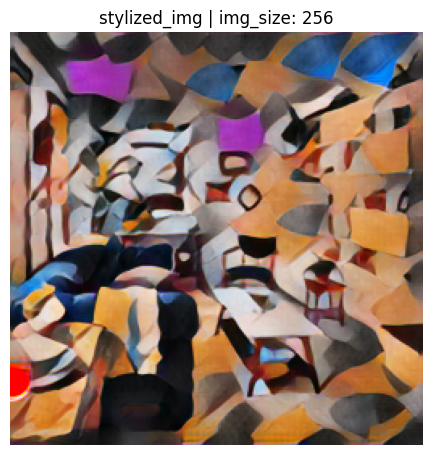

In [19]:
test_transform = get_transform(img_size=(256, 256))
test_img = test_transform(Image.open("/kaggle/working/content_img.jpg")) # you need to change the path outside kaggle environment

image_transformer.eval()
with torch.no_grad():
    test_img = test_img.unsqueeze(0).to(CFG.device)
    stylized_img = (image_transformer(test_img) + 1.0)/2
    
show_images(stylized_img, ['stylized_img | img_size: 256'], rows=1)

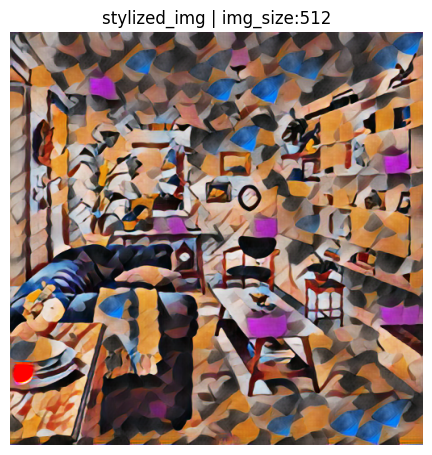

In [20]:
test_transform = get_transform(img_size=(512, 512))
test_img = test_transform(Image.open("/kaggle/working/content_img.jpg")) 

image_transformer.eval()
with torch.no_grad():
    test_img = test_img.unsqueeze(0).to(CFG.device)
    stylized_img = (image_transformer(test_img) + 1.0)/2
    

show_images(stylized_img, ['stylized_img | img_size:512'], rows=1)

# KEY ACHIEVEMENTS & LIMITATIONS

The fast style neural style transfer solves the problem of taking too much time for style transfer proposed by Gatyes and also introduced perceptual losses. But it also suffer from some disadvantages 
1. It only works for one style img where as Gatyes method works for any style. If we want to stylize image with another style we need to train model again.
2. Secondly If you have seen my previous notebook you would see that the stylization of Gatyes paper was much better even though we have to find good hyperparameters for each image and style pair 
3. The stylize image does not look that if test content image size is greater than the content image size used during training. Basically it can not handle images of all shapes

# REFERENCES

1.  Higly Recomended to understand real time style transfer more [Style Transfer in Real-Time](https://shafeentejani.github.io/2017-01-03/fast-style-transfer/)
2. [Fast Neural Style Transfer](https://www.kaggle.com/code/yashchoudhary/fast-neural-style-transfer)
3. [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/abs/1603.08155)
4. [Coco2014](https://www.kaggle.com/datasets/jeffaudi/coco-2014-dataset-for-yolov3)

# WHAT NEXT?

In the next notebook we will see how to solve the first limitation of this model .As for the 2nd and 3rd problem we would learn about later in series.